In [16]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import time
from functools import partial
import qutip.settings
qutip.settings.num_threads = 4
#import sympy as sp
import multiprocessing as mp
import functools
from scipy.sparse import csc_matrix
import scipy.sparse.linalg as sla
import scipy.linalg as sl
import os
from tqdm import tqdm
# import torch

def DH(w, w0, g, M, j):
    
    '''
    This function returns the Dicke Hamiltonian for the following parameters.
    
    Parameters
    ----------
    
    w : frequency of the bosonic field
    
    w0 : Energy difference in spin states
    
    g : Coupling strength
    
    M : Upper limit of bosonic fock states
    
    j : Pseudospin
    
    '''
    a  = qt.tensor(qt.destroy(M),qt.qeye(int(2*j+1)))
    Jp = qt.tensor(qt.qeye(M),qt.jmat(j, '+'))
    Jm = qt.tensor(qt.qeye(M),qt.jmat(j, '-'))
    Jz = qt.tensor(qt.qeye(M),qt.jmat(j, 'z'))
    
    H0 = w * a.dag() * a + w0 * Jz
    H1 = 2.0 / np.sqrt(j) * (a + a.dag()) * (Jp + Jm)
    H = H0 + g * H1
    
    return H

def dSFF_fun(j,M,g,beta,eval_list,tlist,slist):

    if not os.path.exists("SFF"):
        os.mkdir("SFF")

    with open(f"SFF/dSFFvsTime,j={j},M={M},g={g},beta={beta}.dat", 'w') as file:
        # for t_ind, t in tqdm(enumerate(tlist)):
        for s_ind, s in enumerate(slist):
            t=0
            # s=0
            SFF = 0
            norm = 0
            for i,eval1 in (enumerate(eval_list)):
                SFF += np.exp(-(beta+1j*t)*(np.real(eval1))-(beta+1j*s)*(np.imag(eval1)))
                norm += np.exp(-beta*eval1)
            # SFF1 = SFF/norm
            SFF = np.conjugate(SFF)*SFF/(norm**2)
            file.write("\t{}".format(SFF))
            # file.write("\t{}".format(SFF1))
            file.write("\n")

    return 0

### Parameters

In [62]:
S = 1; wc = 1.0;ws=1.0;κ=1.0;
λ1 = 0.2;λ2 = 1.0;λc = 1/np.sqrt(2);
Nphot1 = 2
a  = qt.tensor(qt.destroy(Nphot1),qt.qeye(int(2*S+1)))
HDicke1_subrad = DH(wc, ws, λ1, Nphot1, S)
HDicke1_suprad = DH(wc, ws, λ2, Nphot1, S)
Lop1_subrad = qt.liouvillian(HDicke1_subrad,c_ops=[np.sqrt(κ)*a])
Lop1_suprad = qt.liouvillian(HDicke1_suprad,c_ops=[np.sqrt(κ)*a])
num  = qt.tensor(qt.num(Nphot1),qt.qeye(int(2*S+1)))
Sz = qt.tensor(qt.qeye(Nphot1),qt.jmat(S, 'z'))
β = 0

t_vals_0_to_01 = np.linspace(0, 0.1, 100, endpoint=False)
t_vals_01_to_1 = np.linspace(0.1, 1, 100, endpoint=False)
t_vals_1_to_10 = np.linspace(1, 10, 100, endpoint=False)
t_vals_10_to_100 = np.linspace(10, 100, 100, endpoint=False)
t_vals_100_to_1000 = np.linspace(100, 1000, 100)

# Concatenate them into a single array
tlist = np.concatenate([t_vals_0_to_01, t_vals_01_to_1, t_vals_1_to_10, t_vals_10_to_100, t_vals_100_to_1000])

slist = tlist

## Subradiant

### Calculate Eigenvalues

In [63]:
file_path = f'evals_par_Lop/evals_j={S}_M={Nphot1}_g={λ1}_gam={κ}.npy' 
if not os.path.exists(file_path):
    folder = f'evals_par_Lop'
    if not os.path.exists(folder):
        os.mkdir(folder)
    Lopmatsubrad = Lop1_subrad.data
    Lopmatsubrad = Lopmatsubrad.to_array()
    Lopmatsubrad_even = Lopmatsubrad[::2,::2]
    Lopmatsubrad_odd = Lopmatsubrad[1::2,1::2]

    Ntot = ((2*S+1))*Nphot1/2-2
    Ntot = Ntot*Ntot
    # Lopmatsubrad_even_eigs_sparse = sla.eigs(csc_matrix(Lopmatsubrad_even), k=int(Ntot), sigma=0+0j, which='LM', return_eigenvectors=False, maxiter=2000)
    Lopmatsubrad_even_eigs_sparse = sl.eigvals(Lopmatsubrad_even)
    idx = np.argsort(abs(Lopmatsubrad_even_eigs_sparse.imag))
    Lopmatsubrad_even_eigs_sparse = Lopmatsubrad_even_eigs_sparse[idx]
    np.save(file_path,Lopmatsubrad_even_eigs_sparse)

### Plot Eigenvalues

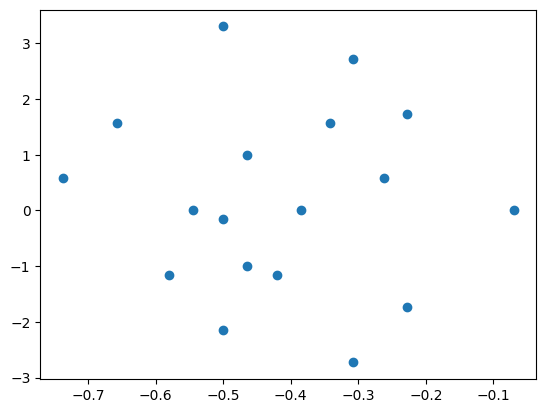

In [64]:
file_path = f'evals_par_Lop/evals_j={S}_M={Nphot1}_g={λ1}_gam={κ}.npy' 
eval_list = np.load(file_path)
plt.scatter(np.real(eval_list),np.imag(eval_list))

In [65]:
np.abs(eval_list.imag)

array([3.13717039e-17, 4.12169450e-17, 1.74859690e-16, 1.50335253e-01,
       5.75167626e-01, 5.75167626e-01, 1.00133727e+00, 1.00133727e+00,
       1.15167252e+00, 1.15167252e+00, 1.57650490e+00, 1.57650490e+00,
       1.72684015e+00, 1.72684015e+00, 2.15300979e+00, 2.72817742e+00,
       2.72817742e+00, 3.30334504e+00])

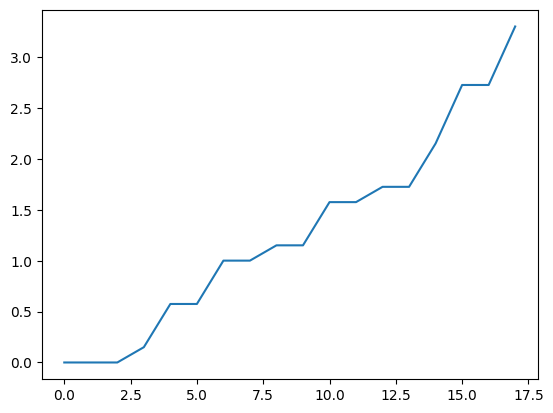

In [66]:
plt.plot(np.abs(eval_list.imag))

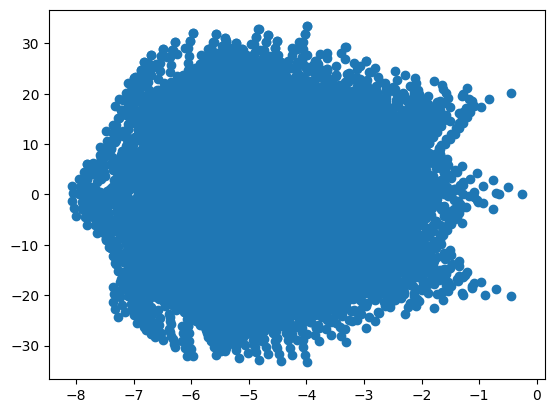

In [58]:
file_path = f'evals_par_Lop/evals_j={S}_M={Nphot1}_g={λ1}_gam={κ}.npy' 
eval_list = np.load(file_path)
plt.scatter(np.real(eval_list),np.imag(eval_list))

### Calculate and Plot SFF

100%|██████████| 500/500 [00:00<00:00, 42656.25it/s]


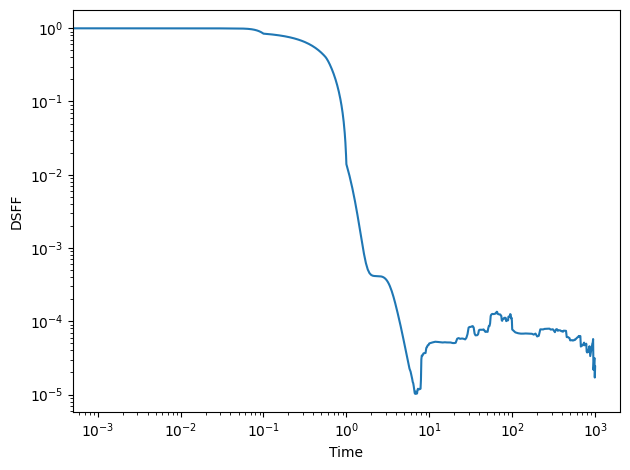

In [13]:
file_path = f'evals_par_Lop/evals_j={S}_M={Nphot1}_g={λ1}_gam={κ}.npy' 
eval_list = np.load(file_path)
file_path = f"SFF/dSFFvsTime,j={S},M={Nphot1},g={λ1},beta={β}.dat"

if not os.path.exists(file_path):
    dSFF_fun(S,Nphot1,λ1,β,eval_list,tlist,slist)

# Open the file and read the first column
dSFF_list = []
with open(file_path, 'r') as file:
    for line in file:
        # Split each line into values and extract the first one
        first_value = complex(line.split()[0])  # Assumes values are tab-separated
        dSFF_list.append(first_value)
dSFF_list = np.real(np.array(dSFF_list))

dSFF_list1_rl = []
# Window size for rolling average
win = 50
for data_ind in tqdm(range(len(dSFF_list))):
    win_start = int(data_ind)
    win_end = int(data_ind+win)
    data_rl_val = np.average(dSFF_list[win_start:win_end], axis=0)
    dSFF_list1_rl.append(data_rl_val)

dSFF_list1_rl = np.column_stack(dSFF_list1_rl)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Time")
plt.ylabel("DSFF")
plt.plot(tlist,dSFF_list1_rl[0])
plt.tight_layout()
plt.show()

## Superradiant

### Calculate Eigenvalues Superradiant Phase

In [4]:
file_path = f'evals_par_Lop/evals_j={S}_M={Nphot1}_g={λ2}_gam={κ}.npy' 
if not os.path.exists(file_path):
    folder = f'evals_par_Lop'
    if not os.path.exists(folder):
        os.mkdir(folder)
    Lopmatsuprad = Lop1_suprad.data
    Lopmatsuprad = Lopmatsuprad.to_array()
    Lopmatsuprad_even = Lopmatsuprad[::2,::2]
    Lopmatsuprad_odd = Lopmatsuprad[1::2,1::2]

    Ntot = (2*S+1)*Nphot1
    # Lopmatsuprad_even_eigs_sparse = sla.eigs(csc_matrix(Lopmatsuprad_even), k=Ntot-2, sigma=0+0j, which='LM', return_eigenvectors=False, maxiter=2000)
    Lopmatsubrad_even_eigs_sparse = sl.eigvals(Lopmatsuprad_even)
    # idx = np.argsort(abs(Lopmatsuprad_even_eigs_sparse.imag))
    # Lopmatsuprad_even_eigs_sparse = Lopmatsuprad_even_eigs_sparse[idx]
    np.save(file_path,Lopmatsubrad_even_eigs_sparse)


### Plot Eigenvalues Superradiant Phase

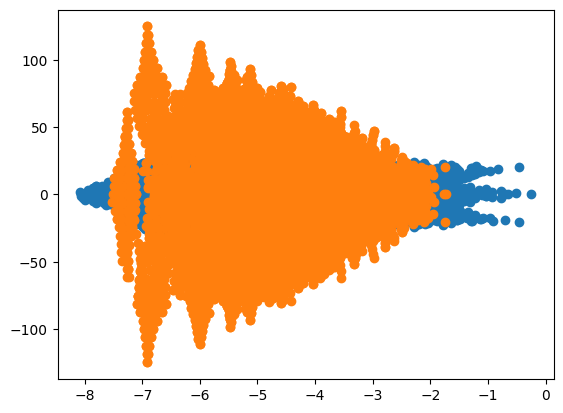

In [6]:
file_path1 = f'evals_par_Lop/evals_j={S}_M={Nphot1}_g={λ1}_gam={κ}.npy' 
file_path2 = f'evals_par_Lop/evals_j={S}_M={Nphot1}_g={λ2}_gam={κ}.npy' 
eval_list1 = np.load(file_path1)
eval_list2 = np.load(file_path2)
plt.scatter(np.real(eval_list1),np.imag(eval_list1))
plt.scatter(np.real(eval_list2),np.imag(eval_list2))

### Calculate and Plot SFF Superradiant Phase

100%|██████████| 500/500 [00:00<00:00, 293842.23it/s]


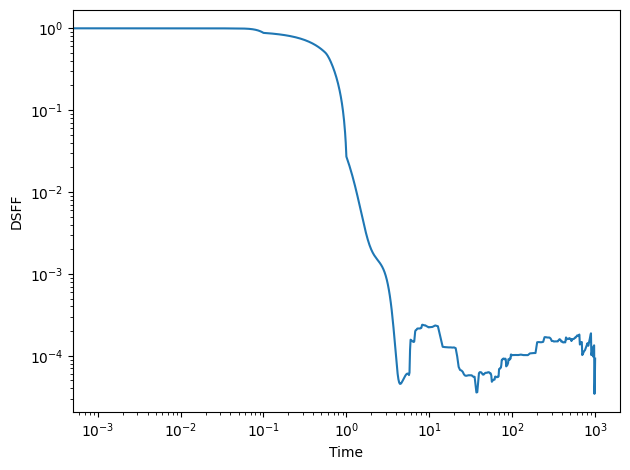

In [14]:
file_path = f'evals_par_Lop/evals_j={S}_M={Nphot1}_g={λ2}_gam={κ}.npy' 
eval_list = np.load(file_path)
file_path = f"SFF/dSFFvsTime,j={S},M={Nphot1},g={λ2},beta={β}.dat"

if not os.path.exists(file_path):
    dSFF_fun(S,Nphot1,λ2,β,eval_list,tlist,slist)

# Open the file and read the first column
dSFF_list = []
with open(file_path, 'r') as file:
    for line in file:
        # Split each line into values and extract the first one
        first_value = complex(line.split()[0])  # Assumes values are tab-separated
        dSFF_list.append(first_value)
dSFF_list = np.real(np.array(dSFF_list))

dSFF_list2_rl = []
# Window size for rolling average
win = 50
for data_ind in tqdm(range(len(dSFF_list))):
    win_start = int(data_ind)
    win_end = int(data_ind+win)
    data_rl_val = np.average(dSFF_list[win_start:win_end], axis=0)
    dSFF_list2_rl.append(data_rl_val)

dSFF_list2_rl = np.column_stack(dSFF_list2_rl)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Time")
plt.ylabel("DSFF")
plt.plot(tlist,dSFF_list2_rl[0])
plt.tight_layout()
plt.show()

## Compare SFF at $\theta=0$

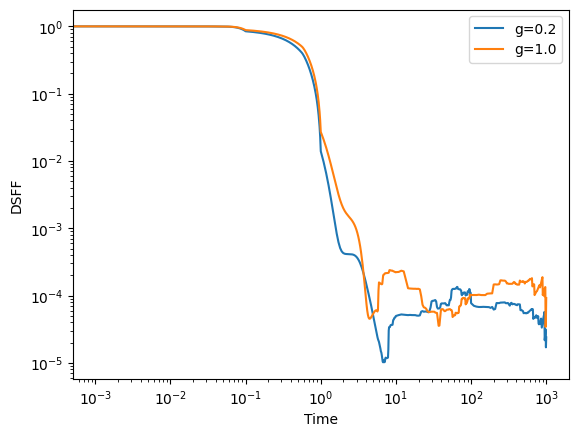

In [15]:
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Time")
plt.ylabel("DSFF")
plt.plot(tlist,dSFF_list1_rl[0],label=f"g={λ1}")
plt.plot(tlist,dSFF_list2_rl[0],label=f"g={λ2}")
plt.legend()